<a href="https://colab.research.google.com/github/ch00226855/CMP414765Spring2022/blob/main/Week05_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5
# Simple Linear Regression and the Normal Equation

So far we have treated machine learning models and their training algorithms mostly like black boxes. Starting from Chapter 4, we will look into the mechanism of several popular machine learning models, analyze them mathematically and learn how to implement the methods from scratch. Let's start with the linear regression model.

**Reading**: Textbook, Chapter 4

## I. Simple Linear regression: Sales Prediction

To put things into context, let's look at a dataset that contains the sales revenue and the advertising budgets of a company in 200 different markets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url = "https://www.statlearning.com/s/Advertising.csv"
advertising = pd.read_csv(url, index_col=0)
advertising.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [ ]:
advertising.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


In [ ]:
advertising.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


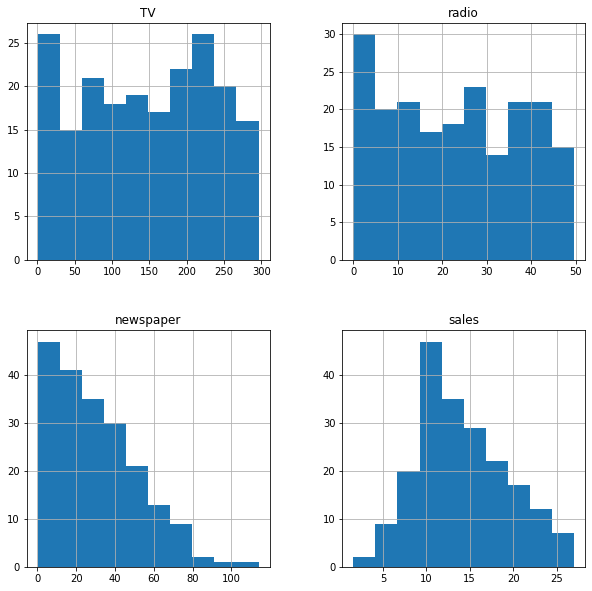

In [ ]:
fig = advertising.hist(figsize=(10, 10))

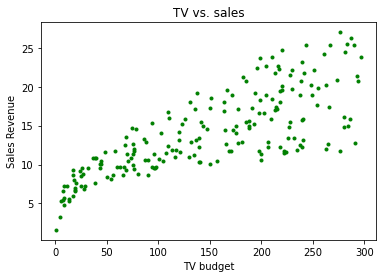

In [ ]:
# plot TV vs. sales
plt.plot(advertising['TV'], advertising['sales'], 'g.')
plt.title("TV vs. sales")
plt.xlabel("TV budget")
plt.ylabel("Sales Revenue")
plt.savefig("TVvsSales.png")
plt.show() # this is needed in other Python environments

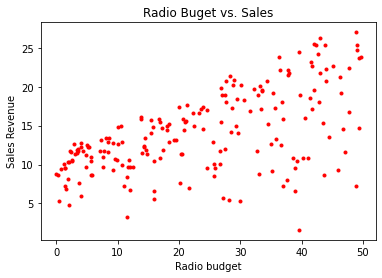

In [ ]:
# Exercise:
# plot radio vs. sales

plt.plot(advertising['radio'], advertising['sales'], 'r.')
plt.title("Radio Buget vs. Sales")
plt.xlabel("Radio budget")
plt.ylabel("Sales Revenue")
plt.savefig("RadioVsSales.png")

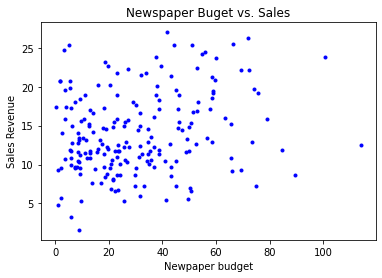

In [ ]:
# Exercise:
# plot newspaper vs. sales

plt.plot(advertising['newspaper'], advertising['sales'], 'b.')
plt.title("Newspaper Buget vs. Sales")
plt.xlabel("Newpaper budget")
plt.ylabel("Sales Revenue")
plt.savefig("NewspaperVsSales.png")

What can we say with these scatter plots?
- There is a strong positive correlation between TV and sales
- There is a positive correlation between radio and sales
- I do not observe a strong correlation between newspaper and sales. 

In [ ]:
# The outcome from the describe() method suggests there are outliers.

# Use a filter to extract the record with 0.7 TV value
advertising[advertising["TV"] == 0.7] # the condition in [] creates a list of boolean indices


,TV,radio,newspaper,sales
131,0.7,39.6,8.7,1.6


In [ ]:
# Sort the records in the ascending order of TV
advertising.sort_values(by="TV", ascending=False, inplace=True)
advertising = advertising.sort_values(by="TV", ascending=False)

In [ ]:
advertising.head()

,TV,radio,newspaper,sales
102,296.4,36.3,100.9,23.8
43,293.6,27.7,1.8,20.7
31,292.9,28.3,43.2,21.4
36,290.7,4.1,8.5,12.8
99,289.7,42.3,51.2,25.4


### Correlation Coefficient: Numerical Measure of Correlations
The **correlation coefficient** is a numerical measurement of **linear correlation** between two variables.
- The value of correlation coefficient always lies in [-1, 1].
- If there is a strong positive correlation, then the coefficient is close to 1.
- If there is a strong negative correlation, then the coefficient is close to -1.
- If there is a very weak correlation, then the coefficient is close to 0.
- However, a near-zero coeffient may be caused by non-linear correlations.
![](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)

In [ ]:
# Calculate pair-wise correlation coefficients
advertising.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


For simplicity, we will only use `TV` as a predictor of `sales`.

In [3]:
data = advertising.loc[:, ['TV', 'sales']] 
# The loc expression require both row indices and column names
data.head()

,TV,sales
1,230.1,22.1
2,44.5,10.4
3,17.2,9.3
4,151.5,18.5
5,180.8,12.9


In [ ]:
# Use the loc expression to find the sale value for row 100
advertising.loc[100, 'sales']

# Use the loc expression to find the sales value for row 50 to 60
advertising = advertising.reset_index(drop=True)
advertising.loc[[50, 52, 69], 'sales']

50    12.2
52    19.4
69    18.3
Name: sales, dtype: float64

## Simple Linear Regression: Model Representation

In order to describe the model mathematically, we need to introduce a few notations:
- The input feature `TV` is represented as variable $X$.
- The output/response feature `sales` is represented as variable $Y$.
- Each instance of data is represented as $(x^{(i)}, y^{(i)})$, where $i$ is the row index, $x^{(i)}$ is the value corresponding to $X$, and $y^{(i)}$ is the value corresponding to $Y$. For example, $(x^{(0)}, y^{(0)}) = (296.4, 23.8)$.
- Let $N$ represent the total number of data. In this case, N = 200.

The **simple linear regression** model assumes that the relationship between $X$ and $Y$ is
$$Y \approx f(X) = \beta_0 + \beta_1 X.$$

- $\beta_0$ and $\beta_1$ are called **model parameters**. For simple linear regression, the relationship is characterized as a straight line with slope $\beta_1$ and y-intercept $\beta_0$.


In [4]:
# Train a linear regression model using sklearn
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(data[['TV']], data[['sales']])

LinearRegression()

In [6]:
# The coef_ and intercept_ attributes contain parameter values
print(model_lr.coef_) # beta_1
print(model_lr.intercept_) # beta_0

[[0.04753664]]
[7.03259355]


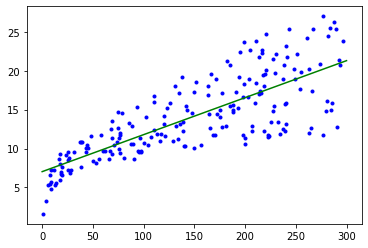

In [9]:
# Plot the data points and the optimal regression line.
m = model_lr.coef_[0, 0]   # slope
b = model_lr.intercept_[0] # y-intercept

plt.plot(data['TV'], data['sales'], 'b.')
x_coordinates = np.array([0,300])
y_coordinates = x_coordinates * m + b
plt.plot(x_coordinates, y_coordinates, 'g-')

## Train A Simple Linear Regression Model

- For a given set of model parameters, we need a **cost function** (in some occasions also called **loss function**) that measures how well a given line fits the data.
- We also need a **training algorithm** that finds values of parameters so that the line fits the data well (usually "fitting the data well" means "minimizing the cost").

For linear regression:
- Cost function: 
    - Mean squared error (MSE)
    - Mean absolute error (MAE)
    - Other variants
- Training algorithm: 
    - Normal equation
    - Gradient descent

## Simple Linear Regression: Cost Function
A common choice of cost function is the **mean squared error (MSE) function**. It is defined as
$$\begin{align}
MSE(\beta_0, \beta_1) =& 
\frac{1}{N}\sum_{i=1}^N (y^{(i)} - f(x^{(i)}))^2 \\
=& \frac{1}{N}\sum_{i=1}^N\big(y^{(i)} - \beta_0 - \beta_1x^{(i)}\big)^2.
\end{align}$$

To better understand the MSE function, let's calculate the value $MSE(7.03, 0.04)$.

In [10]:
# Example:
# Calculate the squared error of the model on the first record.

beta0 = 7.03
beta1 = 0.04

x1 = data.loc[1, 'TV'] # 230.1
y1 = data.loc[1, 'sales'] #22.1
print("x1, y1:", x1, y1)

# Calculate f(x1) = beta0 + beta1 * x1
f_x1 = beta0 + beta1 * x1

# Calculate the squared error (y1 - f(x1)) ** 2
squared_error = (y1 - f_x1) ** 2

# squared_error = (y1 - beta0 - beta1 * x1) ** 2

print("Squared error from Record 1:", squared_error)

x1, y1: 230.1 22.1
Squared error from Record 1: 34.409955999999994


In [19]:
# Example:
# Calculate the squared error of the model on an arbitrary record.

beta0 = 7.03
beta1 = 0.04

i = 100  # index of the record
xi = data.loc[i, 'TV']
yi = data.loc[i, 'sales']
print("xi, yi:", xi, yi)

# Calculate f(xi)
f_xi = beta0 + beta1 * xi

# Calculate the squared error (yi - f(xi)) ** 2
squared_error = (yi - f_xi) ** 2

print("Squared error for Record %d:" % i, squared_error)

xi, yi: 135.2 17.2
Squared error for Record 100: 22.676644000000003


In [13]:
# data[data.index == i]

,TV,sales
100,135.2,17.2


In [20]:
# Write a function that produces the squared error given beta0, beta1, data, and i
def get_squared_error(beta0, beta1, data, i):

    xi = data.loc[i, 'TV']
    yi = data.loc[i, 'sales']
    # print("xi, yi:", xi, yi)

    # Calculate f(xi)
    f_xi = beta0 + beta1 * xi

    # Calculate the squared error (yi - f(xi)) ** 2
    squared_error = (yi - f_xi) ** 2

    return squared_error

In [25]:
get_squared_error(7.03, 0.04, data, 100)

22.676644000000003

In [26]:
# Create a list that contains value of (y_1 - f(x_1))^2 for i=1,...,200.
list_errors = []
for ind in data.index:
    # call function `get_sqaured_error` with ind
    squared_error = get_squared_error(7.03, 0.04, data, ind)
    # append squared error to `list_errors`
    list_errors.append(squared_error)
    
print(list_errors)

[34.409955999999994, 2.5280999999999993, 2.5027240000000024, 29.2681, 1.8550440000000004, 0.031683999999999976, 6.100900000000003, 1.8550439999999955, 6.6254760000000035, 19.55408400000002, 1.1534759999999997, 3.1755240000000002, 1.4835239999999978, 1.512900000000001, 14.485636000000007, 57.06291599999998, 7.606563999999995, 37.38099600000001, 2.256004000000002, 2.815683999999997, 4.990755999999992, 16.208675999999997, 3.833764000000001, 0.4382440000000034, 0.031683999999999664, 30.758115999999994, 5.080515999999998, 0.538756, 3.678723999999997, 0.417316000000001, 7.043716, 0.1253160000000007, 1.7371240000000037, 0.06451600000000068, 1.8441640000000015, 34.31616400000001, 59.19763599999999, 21.92112399999999, 1.8117159999999954, 28.622499999999977, 2.160900000000007, 8.940100000000012, 3.709475999999994, 5.7888360000000025, 0.21715599999999935, 0.7499560000000025, 0.00032400000000002457, 43.21747599999998, 1.7371239999999943, 3.600000000000273e-05, 13.118884000000012, 0.119716000000000

In [27]:
# Create list_errors using list comprehension

list_errors = [get_squared_error(7.03, 0.04, data, ind) for ind in data.index]
print(list_errors)

[34.409955999999994, 2.5280999999999993, 2.5027240000000024, 29.2681, 1.8550440000000004, 0.031683999999999976, 6.100900000000003, 1.8550439999999955, 6.6254760000000035, 19.55408400000002, 1.1534759999999997, 3.1755240000000002, 1.4835239999999978, 1.512900000000001, 14.485636000000007, 57.06291599999998, 7.606563999999995, 37.38099600000001, 2.256004000000002, 2.815683999999997, 4.990755999999992, 16.208675999999997, 3.833764000000001, 0.4382440000000034, 0.031683999999999664, 30.758115999999994, 5.080515999999998, 0.538756, 3.678723999999997, 0.417316000000001, 7.043716, 0.1253160000000007, 1.7371240000000037, 0.06451600000000068, 1.8441640000000015, 34.31616400000001, 59.19763599999999, 21.92112399999999, 1.8117159999999954, 28.622499999999977, 2.160900000000007, 8.940100000000012, 3.709475999999994, 5.7888360000000025, 0.21715599999999935, 0.7499560000000025, 0.00032400000000002457, 43.21747599999998, 1.7371239999999943, 3.600000000000273e-05, 13.118884000000012, 0.119716000000000

In [29]:
# Calculate the MSE

MSE = sum(list_errors) / len(list_errors)

print("MSE:", MSE)

MSE: 12.163113119999997


In [30]:
# Write a function MSE(beta0, beta1, data) that returns the value of MSE with given beta0 and beta1.
def get_MSE(beta0, beta1, data):

    list_errors = [get_squared_error(beta0, beta1, data, ind) for ind in data.index]

    MSE = sum(list_errors) / len(list_errors)

    return MSE

Now, use function `get_MSE` to obtain the MSE for the following two sets of parameter values
- Case 1: $\beta_0 = 7.03, \beta_1 = 0.04$
- Case 2: $\beta_0 = 5, \beta_1 = 1$

Which one fits the data better?

In [33]:
get_MSE(7.04, 0.04, data)

12.140997119999994

Now that we have obtained the cost function, our next goal is to find the parameter values that minimizes the cost value.

In [34]:
data

,TV,sales
1,230.1,22.1
2,44.5,10.4
3,17.2,9.3
4,151.5,18.5
5,180.8,12.9
...,...,...
196,38.2,7.6
197,94.2,9.7
198,177.0,12.8
199,283.6,25.5


# Simple Linear Regression: Training Algorithm
To find the value of $\beta_0, \beta_1$ that minimizes the MSE cost function, there is a formula called the **normal equation** that gives the result directly:

$$\begin{pmatrix} \beta_0 \\ \beta_1 \end{pmatrix} = (\textbf{X}^T\cdot\textbf{X})^{-1}\cdot\textbf{X}^T\cdot\textbf{y}.$$

- $\textbf{X}$ is the matrix formed as 
$$\textbf{X} = \begin{pmatrix} 
1 & x^{(1)} \\
1 & x^{(2)} \\
\vdots & \vdots \\
1 & x^{(N)} \\
\end{pmatrix}.$$
- $\textbf{X}^T$ represents the **matrix transpose** of $\textbf{X}$.
- $\cdot$ represents **matrix multiplication**.
- $^{-1}$ represents **matrix inverse**.
- $\textbf{y}$ is the vector of target values
$$\textbf{y} = \begin{pmatrix} 
y^{(1)} \\
y^{(2)} \\
\vdots \\
y^{(N)} \\
\end{pmatrix}.$$

Let's apply the normal equation and find the best parameter values.

In [35]:
# Construct X and y as numpy arrays
X = np.hstack([np.ones([len(data), 1]), data[['TV']].values])
# print(X)
y = data[['sales']].values
# print(y)

beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
# np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print(beta)

[[7.03259355]
 [0.04753664]]


In [36]:
get_MSE(7.03, 0.047, data)

10.52140766755

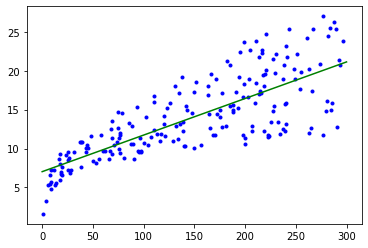

In [37]:
# Plot the data points and the optimal regression line.
plt.plot(data['TV'], data['sales'], 'b.')
x_coordinates = np.array([0,300])
y_coordinates = x_coordinates * 0.047 + 7.03
plt.plot(x_coordinates, y_coordinates, 'g-')